We aim to predict travel time minutes per trip id using features like route id , hour of the dat and route type 

In [4]:
#libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import os
from sklearn.impute import SimpleImputer
print(os.getcwd())

e:\amihere\Hackathon\umpire\data\modeling


In [12]:
base_path = r"https://raw.githubusercontent.com/adobea-dev/umpire/main/gtfs-accra-ghana-2016"
stop_times = pd.read_csv(f"{base_path}/stop_times.csv")
trips = pd.read_csv(f"{base_path}/trips.csv")
routes = pd.read_csv(f"{base_path}/routes.csv")
calendar = pd.read_csv(f"{base_path}/calendar.csv")
shapes = pd.read_csv(f"{base_path}/shapes.csv")
stops = pd.read_csv(f"{base_path}/stops.csv")
fare_rules = pd.read_csv(f"{base_path}/fare_rules.csv")
fare_attributes = pd.read_csv(f"{base_path}/fare_attributes.csv")
agency = pd.read_csv(f"{base_path}/agency.csv")

In [5]:
routes   #split route long name  should be add to df , and used for prediction add hour of the day too, 

,route_id,route_short_name,agency_id,route_long_name,route_type
0,385B,385B,15,37 Station to New Town Station,3
1,056A,056A,67,Abeka lapaz to Race Course,3
2,277B,277B,51,C to Kaneshie Mamprobi Station,3
3,311A,311A,57,Kotobabi Down Station to Accra New Tema Station,3
4,200A,200A,31,Circle Odorna Station to New Melcom,3
...,...,...,...,...,...
646,165B,165B,54,Odorkor Station to Arena Station,3
647,036B,036B,5,Agbogbloshie Station No. 2 to Abeka lapaz,3
648,366B,366B,0,Agbogbloshie Station No. 2 to New Fadama,3
649,266B,266B,92,Afropa to Kaneshie Mkt Cmplx,3


In [13]:
agency

,agency_id,agency_name,agency_url,agency_timezone
0,0,NaN,https://en.wikipedia.org/wiki/Ghana_Private_Ro...,Africa/Accra
1,1,Abeka Lapaz Circle Accra Local of Abeka Branch...,https://en.wikipedia.org/wiki/Ghana_Private_Ro...,Africa/Accra
2,2,Abeka Lapaz Highway (GPRTU),https://en.wikipedia.org/wiki/Ghana_Private_Ro...,Africa/Accra
3,3,Abeka Lapaz Madina Adenta (Novotel) Branch of ...,https://en.wikipedia.org/wiki/Ghana_Private_Ro...,Africa/Accra
4,4,Abeka Trotro Branch of GPRTU,https://en.wikipedia.org/wiki/Ghana_Private_Ro...,Africa/Accra
...,...,...,...,...
86,65,Lapaz Branch of Tiger Transport Services Assoc...,https://en.wikipedia.org/wiki/Ghana_Private_Ro...,Africa/Accra
87,72,Newtown Nima Maamobi Local (Ayawaso Taxi) GPRTU,https://en.wikipedia.org/wiki/Ghana_Private_Ro...,Africa/Accra
88,78,Nkwahia Co-operative Transport Society Limited,https://en.wikipedia.org/wiki/Ghana_Private_Ro...,Africa/Accra
89,94,Lapaz Branch of Tiger Transport Services Assoc...,https://en.wikipedia.org/wiki/Ghana_Private_Ro...,Africa/Accra


In [14]:
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,651001,5.567347,-0.216433,113
1,1001,5.607725,-0.246924,2
2,1001,5.607516,-0.247544,3
3,1001,5.607274,-0.248139,4
4,1001,5.606926,-0.248921,5
...,...,...,...,...
86372,651001,5.566694,-0.214837,109
86373,651001,5.566445,-0.214769,110
86374,651001,5.566071,-0.216071,111
86375,651001,5.566811,-0.216261,112


In [15]:
calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,service,1,1,1,1,1,1,1,20150520,20170531


### Calculating travel time per trip

In [17]:
#convert times to timedelta
stop_times["arrival_time"] = pd.to_timedelta(stop_times["arrival_time"], errors = "coerce")
stop_times["departure_time"] = pd.to_timedelta(stop_times["departure_time"], errors = "coerce")

#trip start and end times
trip_durations = (
    stop_times.groupby('trip_id')
    .agg(start_time=('departure_time', 'min'), end_time=('arrival_time', 'max'))
    .reset_index()
)

# Calculate travel time in minutes
trip_durations['travel_time_minutes'] = (trip_durations['end_time'] - trip_durations['start_time']).dt.total_seconds() / 60
trip_durations.head()

,trip_id,start_time,end_time,travel_time_minutes
0,002A_1,0 days 12:51:38,0 days 13:10:58,19.333333
1,002B_1,0 days 13:16:27,0 days 13:44:40,28.216667
2,003A_1,0 days 13:51:37,0 days 14:45:08,53.516667
3,003B_1,0 days 15:28:50,0 days 15:55:50,27.000000
4,004A_1,0 days 13:22:52,0 days 14:09:22,46.500000


### Feature Engineering - Route info + hour of day

In [18]:
print(trips.columns.tolist())

['route_id', 'service_id', 'trip_id', 'shape_id']


In [19]:
# Merge trip_durations with trips.csv
trip_durations = trip_durations.merge(trips[['trip_id', 'route_id', 'service_id']], on='trip_id', how='left')

# Merge with routes.csv to get route_type
trip_durations = trip_durations.merge(routes[['route_id', 'route_type']], on='route_id', how='left')

# Get the first stop (where trip starts)
first_stops = stop_times.groupby('trip_id').first().reset_index()

# Extract hour from departure time
first_stops['hour_of_day'] = first_stops['departure_time'].dt.components['hours']  #this feature is to represent what time of day a trip starts. helps with rush hour  

# Merge hour_of_day into the trip_durations DataFrame
df = trip_durations.merge(first_stops[['trip_id', 'hour_of_day']], on='trip_id', how='left')
df.head()

,trip_id,start_time,end_time,travel_time_minutes,route_id,service_id,route_type,hour_of_day
0,002A_1,0 days 12:51:38,0 days 13:10:58,19.333333,002A,service,3,12
1,002B_1,0 days 13:16:27,0 days 13:44:40,28.216667,002B,service,3,13
2,003A_1,0 days 13:51:37,0 days 14:45:08,53.516667,003A,service,3,13
3,003B_1,0 days 15:28:50,0 days 15:55:50,27.000000,003B,service,3,15
4,004A_1,0 days 13:22:52,0 days 14:09:22,46.500000,004A,service,3,13


### calculating total distance in km for each shape id

In [20]:
# Sort points in order
shapes_sorted = shapes.sort_values(by=['shape_id', 'shape_pt_sequence'])

# Function to compute distance along a shape
def compute_shape_distance(df):
    total_distance = 0
    for i in range(1, len(df)):
        point1 = (df.iloc[i - 1]['shape_pt_lat'], df.iloc[i - 1]['shape_pt_lon'])
        point2 = (df.iloc[i]['shape_pt_lat'], df.iloc[i]['shape_pt_lon'])
        total_distance += geodesic(point1, point2).kilometers
    return total_distance

# Group by shape_id and calculate distance
shape_distances = shapes_sorted.groupby('shape_id').apply(compute_shape_distance).reset_index()
shape_distances.columns = ['shape_id', 'trip_distance_km']

In [21]:
#merging with the total distance with trip data 
# Merge shape_id into your main df
df = df.merge(trips[['trip_id', 'shape_id']], on='trip_id', how='left')

# Merge trip_distance_km from shape_distances
df = df.merge(shape_distances, on='shape_id', how='left')

In [22]:
df.head()

,trip_id,start_time,end_time,travel_time_minutes,route_id,service_id,route_type,hour_of_day,shape_id,trip_distance_km
0,002A_1,0 days 12:51:38,0 days 13:10:58,19.333333,002A,service,3,12,277001,5.243838
1,002B_1,0 days 13:16:27,0 days 13:44:40,28.216667,002B,service,3,13,278001,4.676327
2,003A_1,0 days 13:51:37,0 days 14:45:08,53.516667,003A,service,3,13,380001,8.391710
3,003B_1,0 days 15:28:50,0 days 15:55:50,27.000000,003B,service,3,15,381001,7.823915
4,004A_1,0 days 13:22:52,0 days 14:09:22,46.500000,004A,service,3,13,554001,28.015865


In [23]:
#adding day of the week/weekend
# Melt it to long format to create (service_id, day_name, is_active)
calendar_long = calendar.melt(
    id_vars=['service_id'],
    value_vars=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'],
    var_name='day_name',
    value_name='is_active'
)

# Filter only active days
calendar_long = calendar_long[calendar_long['is_active'] == 1]

# Merge calendar info to trip_durations using service_id
df = df.merge(calendar_long, on='service_id', how='left')

# Optional: create is_weekend / is_weekday
df['is_weekend'] = df['day_name'].isin(['saturday', 'sunday']).astype(int)
df['is_weekday'] = 1 - df['is_weekend']
#the model will now havr context like "this route runs on weekends which can influence travel time and demand due to traffic patterns

In [24]:
#adding routes name to df
df = df.merge(routes[['route_id', 'route_long_name']], on='route_id', how='left')

In [25]:
df['route_long_name'].isnull().sum()

224

In [26]:
df = df.dropna(subset=['route_long_name'])

In [27]:
# Split into two new columns
df[['origin', 'destination']] = df['route_long_name'].str.split(" to ", expand=True)

In [28]:
print(df.head())

  trip_id      start_time        end_time  travel_time_minutes route_id  \
0  002A_1 0 days 12:51:38 0 days 13:10:58            19.333333     002A   
1  002A_1 0 days 12:51:38 0 days 13:10:58            19.333333     002A   
2  002A_1 0 days 12:51:38 0 days 13:10:58            19.333333     002A   
3  002A_1 0 days 12:51:38 0 days 13:10:58            19.333333     002A   
4  002A_1 0 days 12:51:38 0 days 13:10:58            19.333333     002A   

  service_id  route_type  hour_of_day  shape_id  trip_distance_km   day_name  \
0    service           3           12    277001          5.243838     monday   
1    service           3           12    277001          5.243838    tuesday   
2    service           3           12    277001          5.243838  wednesday   
3    service           3           12    277001          5.243838   thursday   
4    service           3           12    277001          5.243838     friday   

   is_active  is_weekend  is_weekday               route_long_name  

In [29]:
df.shape  # returns (num_rows, num_columns)

(4333, 17)

In [30]:
df.isnull().sum()

trip_id                0
start_time             0
end_time               0
travel_time_minutes    0
route_id               0
service_id             0
route_type             0
hour_of_day            0
shape_id               0
trip_distance_km       0
day_name               0
is_active              0
is_weekend             0
is_weekday             0
route_long_name        0
origin                 0
destination            0
dtype: int64

In [31]:
#input features and target
# Define input features and target
features = ['route_type', 'hour_of_day', 'trip_distance_km', 'day_name', 'origin', 'destination']  #because the features known before the trip starts. route type ; diff vehicles = diff speeds and hour of the day tells us morning rush , low traffic etc 
X = df[features]
y = df['travel_time_minutes']    #add route id  

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Identify all numerical and categorical columns
numerical_cols = [
    'hour_of_day',
    'trip_distance_km',
    ]
categorical_cols = [
    'route_type',
    'day_name',
    'origin',
    'destination',
    ]

# Define preprocessing for numerical data (Imputation + Scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # Scale numerical features
])
# Define preprocessing for categorical data (Imputation + Encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical values to numeric
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),  # Process all num cols
        ('cat', categorical_transformer, categorical_cols)  # Process all cat cols
    ]
)

In [34]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [35]:
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['num__hour_of_day', 'num__trip_distance_km', 'cat__route_type_3',
       'cat__day_name_friday', 'cat__day_name_monday',
       'cat__day_name_saturday', 'cat__day_name_sunday',
       'cat__day_name_thursday', 'cat__day_name_tuesday',
       'cat__day_name_wednesday', 'cat__origin_37 Lorry Park',
       'cat__origin_37 Station', 'cat__origin_A',
       'cat__origin_A-Lang Station', 'cat__origin_Abeka Market station',
       'cat__origin_Abeka lapaz', 'cat__origin_Abelemkpe Station',
       'cat__origin_Ablekuma', 'cat__origin_Abossey Okai Camara Station',
       'cat__origin_Accra Bishop', 'cat__origin_Accra CMB',
       'cat__origin_Accra End of Motorway',
       'cat__origin_Accra New Tema Station',
       'cat__origin_Accra New Town Station',
       'cat__origin_Accra Post Office', 'cat__origin_Accra Taxi Rank',
       'cat__origin_Accra UTC', 'cat__origin_Accra UTC Taxi Rank',
       'cat__origin_Accra Zongo Lane', 'cat__origin_Achimota',
       'cat__origin_Achimota Statio

In [36]:
#Convert to DataFrame 
X_train_df = pd.DataFrame(X_train_processed.toarray(), columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed.toarray(), columns=feature_names)

In [37]:
#baseline model 
#lr_model = LinearRegression()
#lr_model.fit(X_train_dense, y_train)
#lr_preds = lr_model.predict(X_test_dense)
#print("Linear Regression MAE:", round(mean_absolute_error(y_test, lr_preds), 2), "minutes")

In [38]:
rf_model_travel_time = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_travel_time.fit(X_train_df, y_train)
y_pred = rf_model_travel_time.predict(X_test_df)

rf_mae = mean_absolute_error(y_test, y_pred)
print("Random Forest MAE with distance:", round(mean_absolute_error(y_test, y_pred), 2), "minutes")    #the output should be there

Random Forest MAE with distance: 0.24 minutes


In [39]:
comparison_df = pd.DataFrame({
    'Actual (min)': y_test.values,
    'Predicted (min)': y_pred
})

# Display the top rows
print(comparison_df.head(10))

   Actual (min)  Predicted (min)
0     12.133333        12.256667
1     37.500000        37.500000
2     20.050000        20.050000
3     53.516667        53.516667
4     35.416667        35.367000
5      7.250000         7.250000
6     17.050000        17.000500
7     32.900000        32.900000
8     33.650000        33.661500
9     29.116667        29.253500


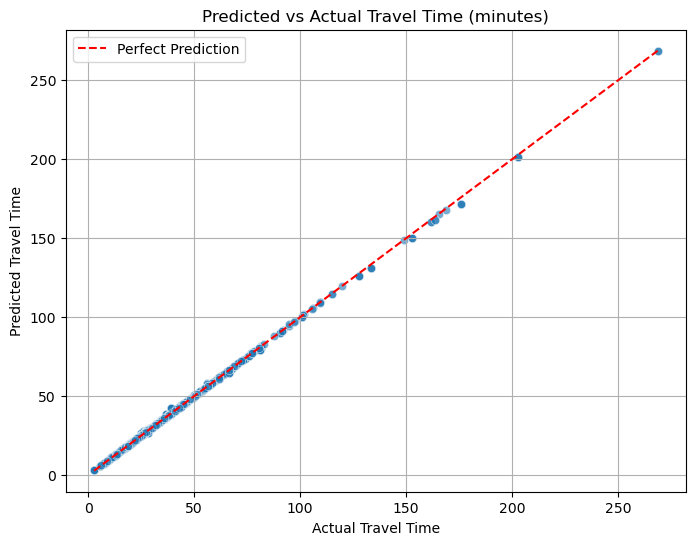

In [40]:
# Make predictions
y_pred = rf_model_travel_time.predict(X_test_df)

# Create a DataFrame for plotting
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect Prediction')
plt.title('Predicted vs Actual Travel Time (minutes)')
plt.xlabel('Actual Travel Time')
plt.ylabel('Predicted Travel Time')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
##indicator of a well performing model

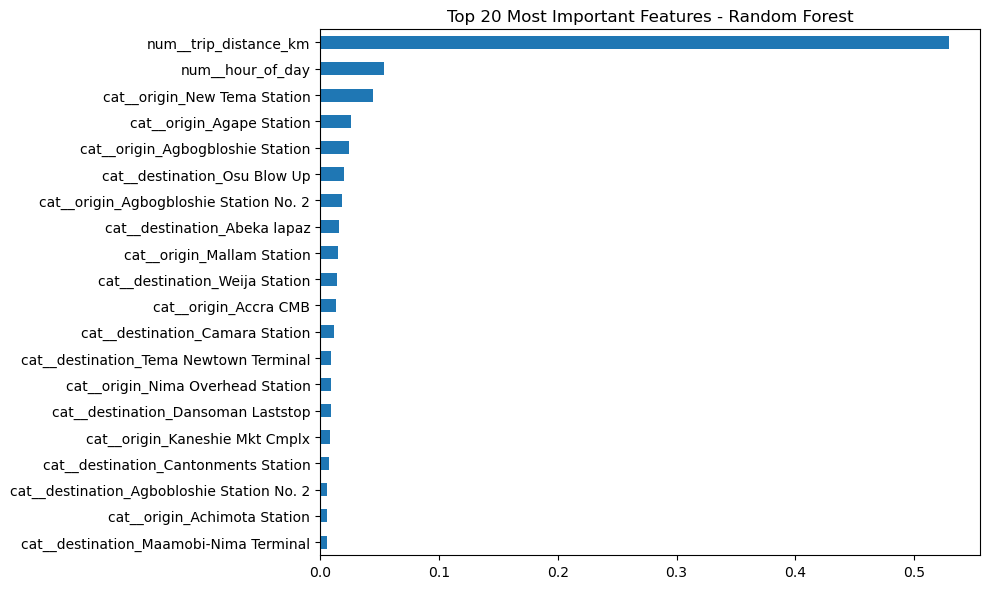

In [42]:
top_n = 20
feature_importance = pd.Series(rf_model_travel_time.feature_importances_, index=X_train_df.columns)
top_features = feature_importance.sort_values(ascending=False).head(top_n)

# Plot
top_features.plot(kind='barh', figsize=(10, 6))
plt.title(f"Top {top_n} Most Important Features - Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [43]:
#trying XGBoost
# Train the model
#xgb_model = XGBRegressor(random_state=42)
#xgb_model.fit(X_train, y_train)

# Predict
#xgb_preds = xgb_model.predict(X_test)

# Evaluate
#xgb_mae = mean_absolute_error(y_test, xgb_preds)
#print(f"XGBoost MAE: {xgb_mae:.2f} minutes")

## demand prediction

In [44]:
df.columns

Index(['trip_id', 'start_time', 'end_time', 'travel_time_minutes', 'route_id',
       'service_id', 'route_type', 'hour_of_day', 'shape_id',
       'trip_distance_km', 'day_name', 'is_active', 'is_weekend', 'is_weekday',
       'route_long_name', 'origin', 'destination'],
      dtype='object')

In [45]:
agency.columns

Index(['agency_id', 'agency_name', 'agency_url', 'agency_timezone'], dtype='object')

In [46]:
pivot_df = df.groupby(['route_id', 'day_name'])['trip_id'].nunique().reset_index()
pivot_df = pivot_df.merge(routes[['route_id', 'agency_id']], on='route_id', how='left')
# First, count trips by route + day
trip_summary = pivot_df.groupby(['agency_id', 'day_name'])['trip_id'].sum().reset_index()

In [47]:
pivot_df = df.groupby(['route_id', 'day_name'])['trip_id'].nunique().reset_index()
pivot_df = pivot_df.merge(routes[['route_id', 'agency_id']], on='route_id', how='left')
# First, count trips by route + day
trip_summary = pivot_df.groupby(['agency_id', 'day_name'])['trip_id'].sum().reset_index()

In [48]:
trip_summary

,agency_id,day_name,trip_id
0,0,friday,34
1,0,monday,34
2,0,saturday,34
3,0,sunday,34
4,0,thursday,34
...,...,...,...
604,101,saturday,2
605,101,sunday,2
606,101,thursday,2
607,101,tuesday,2


In [49]:
# Optional: Pivot to get agency-day as rows, days as columns
trip_pivot = trip_summary.pivot(index='agency_id', columns='day_name', values='trip_id').fillna(0)

In [50]:
trip_pivot

day_name,friday,monday,saturday,sunday,thursday,tuesday,wednesday
agency_id,,,,,,,
0,34,34,34,34,34,34,34
1,2,2,2,2,2,2,2
2,11,11,11,11,11,11,11
3,12,12,12,12,12,12,12
4,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...
97,8,8,8,8,8,8,8
98,5,5,5,5,5,5,5
99,6,6,6,6,6,6,6


In [66]:
#Step 2: Supervised Learning
trip_summary['day_name'] = pd.Categorical(
    trip_summary['day_name'],
    categories=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'],
    ordered=True
)

df_model = pd.get_dummies(trip_summary, columns=['day_name'])

X = df_model.drop(['trip_id'], axis=1)
y = df_model['trip_id']

RMSE: 2.28


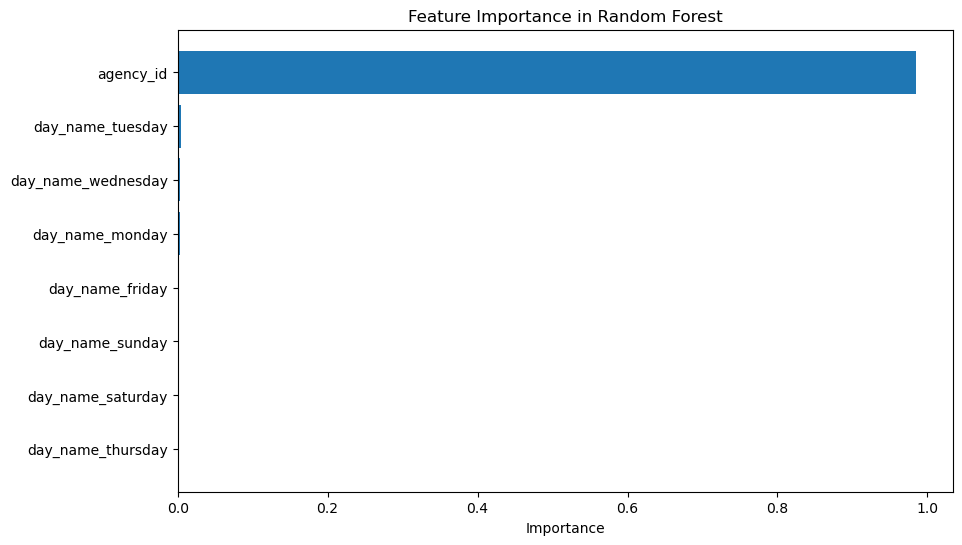

In [59]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train model
rf_model_demand = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_demand.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = rf_model_demand.predict(X_test)

# Step 6: Evaluate model
rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")


# Step 7: Plot feature importance
importances = rf_model_demand.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_df = feat_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_df['feature'], feat_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [53]:
comparison_df = pd.DataFrame({
    'Actual (count of trip id)': y_test.values,
    'Predicted (count of trip id)': y_pred
})

# Display the top rows
print(comparison_df.head(10))

   Actual (count of trip id)  Predicted (count of trip id)
0                         21                         17.09
1                          4                          4.22
2                          7                          6.30
3                          2                          2.48
4                         11                         10.36
5                         16                         14.13
6                          2                          7.18
7                         31                         28.70
8                          2                          2.08
9                          8                          8.50


In [54]:
import joblib

# Define the filename for the saved model
model_filename = 'rf_travel_time_model.joblib'

joblib.dump(rf_model_travel_time, model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to rf_travel_time_model.joblib


In [64]:
# Define the filename for the saved model
model_filename = 'rf_demand_model.joblib'

joblib.dump(rf_model_demand, model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to rf_demand_model.joblib


In [65]:
loaded_model = joblib.load(model_filename)
type(loaded_model)

sklearn.ensemble._forest.RandomForestRegressor

In [ ]:
# Save Your Column List (After Encoding + Feature Selection)
model_columns = features.tolist()
joblib.dump(model_columns, 'rf_travel_time_model.joblib')

AttributeError: 'list' object has no attribute 'tolist'